In [ ]:
!pip install pyspark
!pip install findspark

In [ ]:
from pyspark.sql.types import *

from pyspark.sql.functions import *

from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("my project 2")\
    .config("spark.kryoserializer.buffer.max", "512m")\
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.0')\
        .getOrCreate()
sc = spark.sparkContext


for_students_demo_path = "/mnt/ddscoursedatastorage/ro/fwm-stb-data/proj_B_demographic"
demographic_df = spark.read.parquet(for_students_demo_path)
display(demographic_df)

In [ ]:

kafka_server = "kafka96224.eastus.cloudapp.azure.com:29092"
topic='viewstatic'
OFFSETS_PER_TRIGGER = 50000
SCHEMA = "device_id STRING, event_date STRING, event_time STRING, station_num STRING, prog_code STRING, household_id LONG"

static_df = spark.read\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .load()

static_view_df = static_df.select(from_csv(decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*").na.drop()
display(static_view_df)

## **Normalizing Columns**

In [ ]:
from pyspark.ml.feature import MaxAbsScaler, VectorAssembler
from pyspark.sql import SparkSession


# Columns to normalize
columns_to_normalize = ['household_size', 'num_adults', 'num_generations', 'length_residence', 'home_market_value', 'net_worth', 'education_highest']

# Dictionary to store max values
max_values = {}

# Calculate and save max values
for c in columns_to_normalize:
    max_value = demographic_df.agg(max(col(c))).collect()[0][0]
    max_values[c] = max_value

# Normalize columns
for c in columns_to_normalize:
    demographic_df = demographic_df.withColumn(c, col(c) / max_values[c])

## **One-Hot-Encoding for Categorical Variables**

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Define the columns to be one-hot encoded
columns_to_encode = ['marital_status', 'race_code', 'dwelling_type', 'home_owner_status', 'gender_individual']
indexed = [f"{col}_index" for col in columns_to_encode]
encoded = [f"{col}_vec" for col in columns_to_encode]

#create pipeline
transformer_pipeline = Pipeline(stages=[
    StringIndexer(inputCols = columns_to_encode, outputCols=indexed),
    OneHotEncoder(inputCols=indexed, outputCols=encoded)
])


#create model
model = transformer_pipeline.fit(demographic_df)

#transform dataframe
encoded_df = model.transform(demographic_df)

#get rid of unnecessary columns
demographic_df = encoded_df.drop(*columns_to_encode, *indexed)

## **Combining all columns into one feature vector**

In [ ]:
#getting all columns except for household_id
cols = demographic_df.columns
cols.remove('household_id')
print(cols)

#creating the vector assembler
assembler = VectorAssembler(inputCols=cols, outputCol='features')

# Apply the VectorAssembler to the DataFrame
features_df = assembler.transform(demographic_df)

#getting rid of all columns accept for featuer vector
demographic_df = features_df.select('household_id', 'features').withColumnRenamed('features', 'dense_features')

demographic_df.show(7, truncate=False)

['household_size', 'num_adults', 'num_generations', 'length_residence', 'home_market_value', 'net_worth', 'education_highest', 'marital_status_vec', 'race_code_vec', 'dwelling_type_vec', 'home_owner_status_vec', 'gender_individual_vec']
+------------+--------------------------------------------------------------------------------------------------------------------------------+
|household_id|dense_features                                                                                                                  |
+------------+--------------------------------------------------------------------------------------------------------------------------------+
|85          |[0.2222222222222222,0.16666666666666666,0.6666666666666666,1.0,0.125,0.05,0.25,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0]             |
|2073        |[0.1111111111111111,0.16666666666666666,0.6666666666666666,1.0,0.15,0.1,0.25,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0]               |
|2523        |[0.7777777777777778,1.0,1.0,1

## **Implementing PCA with k=2**

+--------------------+----------------------+
|x_col               |y_col                 |
+--------------------+----------------------+
|-0.35625542326615856|-0.11097025338253631  |
|-1.0925316168664254 |0.12397733233143128   |
|-1.4149098090986307 |-0.9701798366702089   |
|0.06329368821084108 |-1.158369672110097    |
|-1.2929454215296108 |-0.9714139901152653   |
|-1.1192228102668804 |-0.0063753503650831895|
|0.07476265653874331 |-1.1529793790408362   |
+--------------------+----------------------+
only showing top 7 rows

Out[7]: <AxesSubplot:xlabel='x_col', ylabel='y_col'>

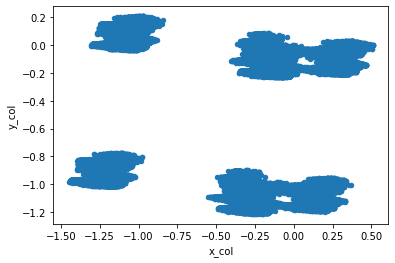

In [ ]:
from pyspark.ml.feature import PCA
from pyspark.ml.functions import vector_to_array


#Create a VectorAssembler to combine the features into a vector column
assembler = VectorAssembler(inputCols=['dense_features'], outputCol='features')
assembled_df = assembler.transform(demographic_df).drop('dense_features')

#Apply PCA to the assembled DataFrame
pca = PCA(k=2, inputCol='features', outputCol='pca_features')
model = pca.fit(assembled_df)
pca_df = model.transform(assembled_df)

# Convert 'pca_features' to an array of doubles
pca_df = pca_df.withColumn('pca_array', vector_to_array('pca_features')).drop('pca_features')

# Extract the individual elements from the array
pca_df = pca_df.withColumn('x_col', col('pca_array')[0])
pca_df = pca_df.withColumn('y_col', col('pca_array')[1]).select('x_col', 'y_col')

#showing top 7 rows
pca_df.show(7, truncate=False)

#visualize resutls
pca_df.toPandas().plot.scatter(x='x_col', y='y_col')

## **Appying K-means**

In [ ]:
from os import truncate
from pyspark.ml.clustering import KMeans
from pyspark.sql.window import Window
from pyspark.sql.functions import sqrt, sum, pow, col, monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector, Vectors, VectorUDT
from pyspark.sql.types import FloatType


demographic_df = demographic_df.withColumnRenamed('dense_features', 'features').withColumn('features', vector_to_array('features'))

# Apply K-means clustering with k=6 and seed=3
kmeans = KMeans(k=6, seed=3)
model = kmeans.fit(demographic_df)
clustered_df = model.transform(demographic_df)

# Collect centroids
centroids = model.clusterCenters()

# Create a list of rows with the centroids
rows = [(Vectors.dense(c),) for c in centroids]

# Create a DataFrame from the list of rows
centroids_df = spark.createDataFrame(rows, ["centroid"])

# Add id to each centroid
centroids_df = centroids_df.rdd.map(lambda x: x.centroid).zipWithIndex().toDF(['centroid', 'c_id'])

# Joining DataFrames
clustered_df = clustered_df.join(centroids_df, clustered_df["prediction"] == centroids_df["c_id"]).select('household_id', 'features', 'centroid', 'prediction')

euclidean_distance = udf(lambda v1, v2: float(sqrt(Vectors.squared_distance(v1, v2))), FloatType())

# Define a UDF to convert Vector to Array
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Define a UDF to convert a list to a dense Vector
list_to_dense_vector_udf = udf(lambda lst: Vectors.dense(lst), VectorUDT())

# Apply the UDF to create a new dense Vector column
clustered_df = clustered_df.withColumn('features', list_to_dense_vector_udf('features'))

# Define a window specification to calculate the centroid distance
window = Window.partitionBy("prediction")

# Define a UDF to calculate the centroid distance
euclidean_distance = udf(lambda v1, v2: float(Vectors.squared_distance(Vectors.dense(v1), Vectors.dense(v2))), FloatType())

# Add a new column that contains the distance of each household id from its centroid
df = clustered_df.withColumn("centroid_distance", euclidean_distance(col('features'), col('centroid'))).drop('features', 'centroid')

# Show 7 rows from the resulting DataFrame
df.show(7, truncate=False)

+------------+----------+-----------------+
|household_id|prediction|centroid_distance|
+------------+----------+-----------------+
|4687979     |0         |0.65198183       |
|4687567     |0         |0.5447349        |
|4196636     |0         |0.3762206        |
|4147377     |0         |0.20357932       |
|4137263     |0         |1.0171916        |
|4112714     |0         |1.0313226        |
|4109225     |0         |1.037621         |
+------------+----------+-----------------+
only showing top 7 rows



## **Calculating Subsets**

In [ ]:
#creating window
window = window.partitionBy('prediction').orderBy('centroid_distance')

#enumerate rows for each cluster
df = df.withColumn('row_number', row_number().over(window))

subsets = {}

for label in [0,1,2,3,4,5]:
  for num in [1,3,17]:
    filtered_df = df.filter((col('prediction') == label) & (col('row_number')%num == 0))
    subsets[f"label{label}_dev{num}"] = filtered_df

## **Checking Clustering Quality**

In [ ]:
#count viewing events per station
df_with_count = static_view_df.groupBy('station_num').agg(count('*').alias('count'))

#summing viewing events
df_with_sum = df_with_count.agg(sum('count').alias('sum')).distinct()

#adding data do counting df
df_with_count = df_with_count.join(df_with_sum, how='left')

#calculating percentage per station for general public
df_with_percentage_gp = df_with_count.withColumn('percentage_general_public', (col('count')/col('sum')) * 100)


for key, df in subsets.items():

  print(f"\n{key}\n")

  #join processed demographic and viewing data
  joined_df = df.join(static_view_df, on='household_id', how='inner')

  #count viewing events per station per subset
  df_with_count = joined_df.groupBy('station_num').agg(count('*').alias('count'))

  #summing viewing events per subset
  df_with_sum = df_with_count.agg(sum('count').alias('sum')).distinct()

  #adding data do counting df
  df_with_count = df_with_count.join(df_with_sum, how='left')

  #calculating percentage per station per subset
  df_with__percentage_pc = df_with_count.withColumn('percentage_subset', (col('count')/col('sum')) * 100)

  #calculating diff-rank measure
  diff_rank_df = df_with__percentage_pc.join(df_with_percentage_gp, on='station_num', how='inner').distinct()
  diff_rank_df = diff_rank_df.withColumn('diff_rank', col('percentage_subset') - col('percentage_general_public')).\
                                                select('station_num', 'diff_rank').orderBy(col('diff_rank').desc())

  diff_rank_df.show(7, truncate=False)


label0_dev1

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|16374      |0.15923312579402493|
|60179      |0.14842073350135188|
|14902      |0.11097756387408242|
|11221      |0.11008892738106524|
|49788      |0.10625692103643791|
|61522      |0.10264767102404004|
|11069      |0.08976342159548512|
+-----------+-------------------+
only showing top 7 rows


label0_dev3

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|61522      |0.18952572513391608|
|11221      |0.1314322885632282 |
|16374      |0.12561276730699822|
|12574      |0.1104979334281202 |
|11765      |0.10076044779147247|
|32677      |0.09119529101194188|
|14909      |0.0886375863169988 |
+-----------+-------------------+
only showing top 7 rows


label0_dev17

+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|16374      |0.6397568153159652 |
|61522      |0.17652513

## **Start Streaming**

In [ ]:
topic = "viewstream"
streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER )\
                  .load()\
                  .select(from_csv(decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")

In [ ]:
from IPython.display import display, clear_output
import time
global batch_num
batch_num = 0

# Create 3rd subsets
trds = {}
for key, df in subsets.items():
    if 'dev3' in key:
        trds[key] = df

def diffrank_batch(batch, epoch_id):
    global batch_num

    batch_num = epoch_id

    if batch_num >= 5:
        return

    # Count viewing events per station
    df_with_count = batch.groupBy('station_num').agg(count('*').alias('count'))

    # Summing viewing events
    df_with_sum = df_with_count.agg(sum('count').alias('sum')).distinct()

    # Adding data to counting df
    df_with_count = df_with_count.join(df_with_sum, how='left')

    # Calculating percentage per station for the general public
    df_with_percentage_gp = df_with_count.withColumn('percentage_general_public', (col('count') / col('sum')) * 100)

    result = {}
    for key, subset in trds.items():

        print(f"{key}_batch_{epoch_id+1}")

        # Join processed demographic and viewing data
        joined_df = subset.join(batch, on='household_id', how='inner')

        # Count viewing events per station per subset
        df_with_count = joined_df.groupBy('station_num').agg(count('*').alias('count'))

        # Summing viewing events per subset
        df_with_sum = df_with_count.agg(sum('count').alias('sum')).distinct()

        # Adding data to counting df
        df_with_count = df_with_count.join(df_with_sum, how='left')

        # Calculating percentage per station per subset
        df_with_percentage_pc = df_with_count.withColumn('percentage_subset', (col('count') / col('sum')) * 100)

        # Calculating diff-rank measure
        diff_rank_df = df_with_percentage_pc.join(df_with_percentage_gp, on='station_num', how='inner').distinct()
        diff_rank_df = diff_rank_df.withColumn('diff_rank', col('percentage_subset') - col('percentage_general_public')) \
                                   .select('station_num', 'diff_rank')

        diff_rank_df.orderBy(col('diff_rank').desc()).show(7)


# Call the diffrank_streaming function using foreachBatch
diff_rank_query = streaming_df.writeStream.foreachBatch(diffrank_batch).start()

while batch_num < 5:
    time.sleep(2)

diff_rank_query.stop()


label0_dev3_batch_1
+-----------+-------------------+
|station_num|          diff_rank|
+-----------+-------------------+
|      32645|0.37672687029659135|
|      11164| 0.3336201859229747|
|      10918|0.25828331119964587|
|      14321|0.24655068614431164|
|      10057|0.22001062416998662|
|      11713|0.19934218680832222|
|      10035|0.18709606020362957|
+-----------+-------------------+
only showing top 7 rows

label1_dev3_batch_1
+-----------+-------------------+
|station_num|          diff_rank|
+-----------+-------------------+
|      16374| 0.3074601226993867|
|      10035|0.30552147239263805|
|      10179| 0.2853006134969327|
|      59303| 0.2174355828220859|
|      32677|0.18812269938650306|
|      60150|  0.175840490797546|
|      60179|0.16919631901840493|
+-----------+-------------------+
only showing top 7 rows

label2_dev3_batch_1
+-----------+-------------------+
|station_num|          diff_rank|
+-----------+-------------------+
|      65342| 0.3237457741717377|
|     